### _Model Testing File_

Imports

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy as sp
import requests
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import problem
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import joblib

### _Loading Data and Processing_

In [3]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [4]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [5]:
df_weather = pd.read_csv("external_data.csv")
df_weather['date'] = pd.to_datetime(df_weather.date)
df_weather.drop(df_weather.columns[0], axis=1, inplace=True)
df_weather.head()

Unnamed: 0                date  Temperature (C) wind_dir  wind_speed  \
0           0 2020-09-01 00:00:00             13.9        N         3.7   
1           1 2020-09-01 01:00:00             13.6      NNO         1.9   
2           2 2020-09-01 02:00:00             13.0      ONO         1.9   
3           3 2020-09-01 03:00:00             12.9       NO         1.9   
4           4 2020-09-01 04:00:00             12.4      ONO         3.7   

   Humidity  Visibility  Precipitation  pressure1  sunshine_time  suntime  \
0      76.0        20.0            0.0     1020.4        21960.0  48255.0   
1      77.0        20.0            0.0     1020.1        21960.0  48255.0   
2      79.0        20.0            0.0     1019.9        21960.0  48255.0   
3      81.0        20.0            0.0     1019.8        21960.0  48255.0   
4      83.0        20.0            0.0     1019.5        21960.0  48255.0   

   new_cases  holidays2  night_time  weekday  weekend_dummy  
0     5104.0          0           1        1              0  
1     5104.0          0           1        1              0  
2     5104.0          0           1        1              0  
3     5104.0          0           1        1              0  
4     5104.0          0           1        1              0

In [6]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [7]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

year  month  day  weekday  hour
48321  2020      9    1        1     2
48324  2020      9    1        1     3
48327  2020      9    1        1     4
48330  2020      9    1        1    15
48333  2020      9    1        1    18

In [8]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[["date"]])[["hour"]].head())

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [9]:
X_train_comb = X_train.join(df_weather.set_index("date"), on="date") 
print(X_train_comb.shape)
X_train_comb["y_train"] = y_train.copy()
X_train_comb.dropna(inplace=True)
print(X_train_comb.shape)

y_train = X_train_comb["y_train"]
X_train_comb.drop("y_train", axis=1, inplace=True)

#Do the same operations for X_test
X_test_comb = X_test.join(df_weather.set_index("date"), on="date") 
print(X_test_comb.shape)
X_test_comb["y_test"] = y_test.copy()
X_test_comb.dropna(inplace=True)
print(X_test_comb.shape)

y_test = X_test_comb["y_test"]
X_test_comb.drop("y_test", axis=1, inplace=True)
X_test_comb.shape, y_test.shape
X_train_comb.head()

(455163, 25)
(455163, 26)
(41608, 25)
(41608, 26)


counter_id                       counter_name    site_id  \
400125  100049407-353255860  152 boulevard du Montparnasse E-O  100049407   
408305  100049407-353255859  152 boulevard du Montparnasse O-E  100049407   
87516   100036719-104036719  18 quai de l'Hôtel de Ville NO-SE  100036719   
98518   100036719-103036719  18 quai de l'Hôtel de Ville SE-NO  100036719   
875137  100063175-353277233          20 Avenue de Clichy NO-SE  100063175   

                            site_name                date  \
400125  152 boulevard du Montparnasse 2020-09-01 01:00:00   
408305  152 boulevard du Montparnasse 2020-09-01 01:00:00   
87516     18 quai de l'Hôtel de Ville 2020-09-01 01:00:00   
98518     18 quai de l'Hôtel de Ville 2020-09-01 01:00:00   
875137            20 Avenue de Clichy 2020-09-01 01:00:00   

       counter_installation_date         coordinates counter_technical_id  \
400125                2018-12-07  48.840801,2.333233          Y2H19070373   
408305                2018-12-07  48.840801,2.333233          Y2H19070373   
87516                 2017-07-12    48.85372,2.35702          Y2H19027732   
98518                 2017-07-12    48.85372,2.35702          Y2H19027732   
875137                2020-07-22    48.88529,2.32666          Y2H20073268   

         latitude  longitude  ...  Visibility  Precipitation pressure1  \
400125  48.840801   2.333233  ...        20.0            0.0    1020.1   
408305  48.840801   2.333233  ...        20.0            0.0    1020.1   
87516   48.853720   2.357020  ...        20.0            0.0    1020.1   
98518   48.853720   2.357020  ...        20.0            0.0    1020.1   
875137  48.885290   2.326660  ...        20.0            0.0    1020.1   

        sunshine_time  suntime  new_cases  holidays2  night_time  weekday  \
400125        21960.0  48255.0     5104.0          0           1        1   
408305        21960.0  48255.0     5104.0          0           1        1   
87516         21960.0  48255.0     5104.0          0           1        1   
98518         21960.0  48255.0     5104.0          0           1        1   
875137        21960.0  48255.0     5104.0          0           1        1   

        weekend_dummy  
400125              0  
408305              0  
87516               0  
98518               0  
875137              0  

[5 rows x 25 columns]

### _Ridge Regression with external data_

In [17]:
# Running Basic Ridge Regression to Test the external data

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                      'Humidity', 'Visibility', 'pressure1','sunshine_time', 'suntime', 'new_cases']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        #("scaler", scaler, numerical_cols)
    ]
)

regressor = Ridge()

pipe0 = make_pipeline(date_encoder, preprocessor, regressor)
pipe0.fit(X_train_comb, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001D43234AA70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'wind_dir'])])),
                ('ridge', Ridge())])

In [18]:
# Declaring a function for our accuracy

def accuracy(pipe):
    mask = (
        (X_test_comb["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
        & (X_test_comb["date"] > pd.to_datetime("2021/09/01"))
        & (X_test_comb["date"] < pd.to_datetime("2021/09/08"))
    )

    df_viz = X_test_comb.loc[mask].copy()
    df_viz["bike_count"] = np.exp(y_test[mask.values]) - 1
    df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_test_comb[mask])) - 1

    fig, ax = plt.subplots(figsize=(12, 4))

    df_viz.plot(x="date", y="bike_count", ax=ax)
    df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
    ax.set_title("Predictions with Ridge")
    ax.set_ylabel("bike_count") 
    
    print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train_comb), squared=False):.2f}"
    )
    print(
        f"Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test_comb), squared=False):.2f}"
    )
    

    print(
        f"Train set, R^2={r2_score(y_train, pipe.predict(X_train_comb)):.2f}"
    )
    print(
        f"Test set, R^2={r2_score(y_test, pipe.predict(X_test_comb)):.2f}"
    )
    return None

Train set, RMSE=0.80
Test set, RMSE=0.72
Train set, R^2=0.77
Test set, R^2=0.75


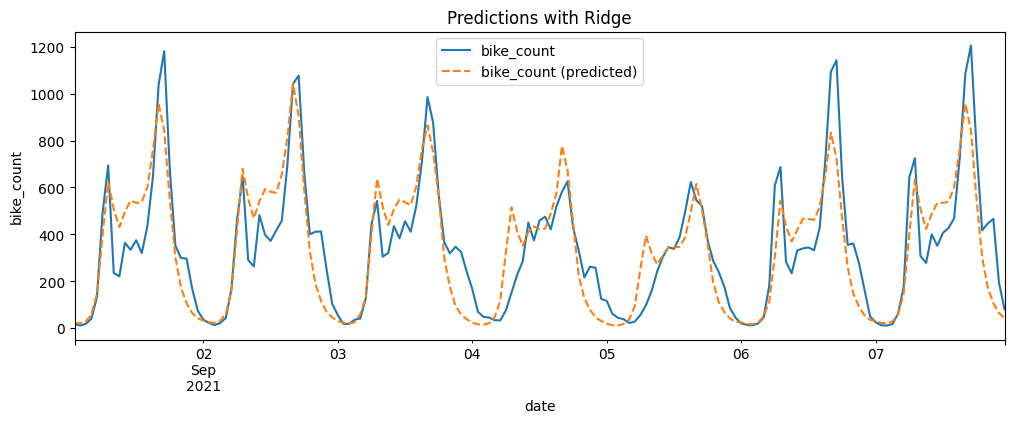

In [19]:
accuracy(pipe0)

# Ensemble Models

## _XGBoost Regressor_

In [12]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name","site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
params = {'learning_rate':[0.1,.05,.2], 'max_depth': [6,8,10],
          'n_estimators':[400,600],'num_parallel_tree': [2], 
          'predictor': ['auto'],  
          'tree_method': ['gpu_hist']}

Boost = XGBRegressor(**params)

pipe1 = make_pipeline(date_encoder, preprocessor, GridSearchCV(Boost,params,cv=4,verbose=10))
pipe1.fit(X_train_comb, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4; 1/18] START learning_rate=0.1, max_depth=6, n_estimators=400, num_parallel_tree=2, predictor=auto, tree_method=gpu_hist
[CV 1/4; 1/18] END learning_rate=0.1, max_depth=6, n_estimators=400, num_parallel_tree=2, predictor=auto, tree_method=gpu_hist;, score=0.810 total time=   8.2s
[CV 2/4; 1/18] START learning_rate=0.1, max_depth=6, n_estimators=400, num_parallel_tree=2, predictor=auto, tree_method=gpu_hist
[CV 2/4; 1/18] END learning_rate=0.1, max_depth=6, n_estimators=400, num_parallel_tree=2, predictor=auto, tree_method=gpu_hist;, score=0.858 total time=   7.6s
[CV 3/4; 1/18] START learning_rate=0.1, max_depth=6, n_estimators=400, num_parallel_tree=2, predictor=auto, tree_method=gpu_hist
[CV 3/4; 1/18] END learning_rate=0.1, max_depth=6, n_estimators=400, num_parallel_tree=2, predictor=auto, tree_method=gpu_hist;, score=0.828 total time=   7.6s
[CV 4/4; 1/18] START learning_rate=0.1, max_depth=6, n_estimators=400, n

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x0000022FD927CEE0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=[400, 600],
                                                     n_jobs=None,
                                                     num_parallel_tree=[2],
                                                     predictor=['auto'],
                                                     random_state=None, ...),
                              param_grid={'learning_rate': [0.1, 0.05, 0.2],
                                          'max_depth': [6, 8, 10],
                                          'n_estimators': [400, 600],
                                          'num_parallel_tree': [2],
                                          'predictor': ['auto'],
                                          'tree_method': ['gpu_hist']},
                              verbose=10))])

In [13]:
BestXBM = pipe1[2].best_estimator_
BestXBM

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=0,
             num_parallel_tree=2, predictor='auto', random_state=0, ...)

Train set, RMSE=0.39
Test set, RMSE=0.51
Train set, R^2=0.95
Test set, R^2=0.87


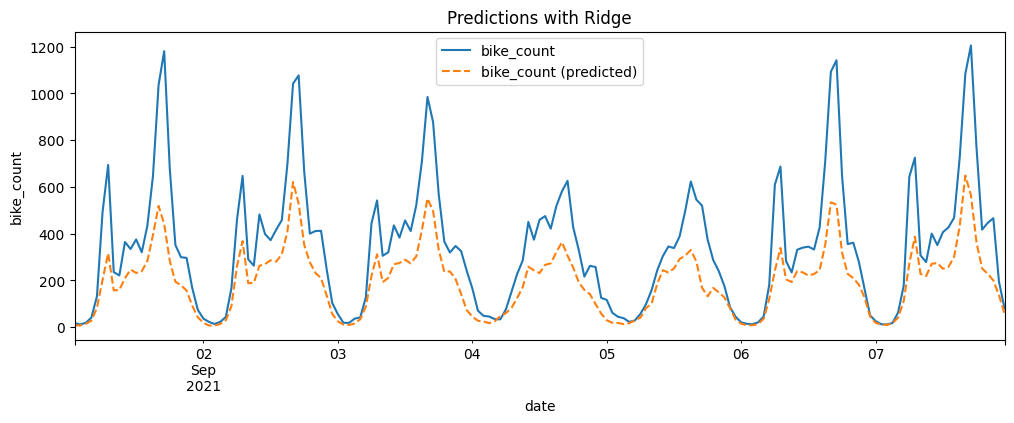

In [14]:
accuracy(pipe1)

## _LightGbm Regressor_

In [32]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = X_train_comb.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
param_grid = {'learning_rate:':[.01,.1,.2],
               'n_estimators':[500,800,1300],
               'max_depth':[8,10,12,],'min_data_in_leaf':[3,4,7],'device':['gpu']}

Boost = LGBMRegressor()

pipe2 =make_pipeline(date_encoder, preprocessor, GridSearchCV(Boost,param_grid,
                                                              cv = 4))
pipe2.fit(X_train_comb, y_train)

[LightGBM] [Warning] Unknown parameter: learning_rate:
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: learning_rate:
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: learning_rate:
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: learning_rate:
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: learning_rate:
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Unknown parameter: learning_rate:
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 w

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001D43234AA70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
       'wind_speed', 'Humidity', 'Visibility', 'Precipitation', 'pressure1',
       'sunshine_time', 'suntime', 'new_cases', 'holidays2', 'night_time',
       'weekday', 'weekend_dummy'],
      dtype='object'))])),
                ('gridsearchcv',
                 GridSearchCV(cv=4, estimator=LGBMRegressor(),
                              param_grid={'device': ['gpu'],
                                          'learning_rate:': [0.01, 0.1, 0.2],
                                          'max_depth': [8, 10, 12],
                                          'min_data_in_leaf': [3, 4, 7],
                                          'n_estimators': [500, 800, 1300]}))])

In [41]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                      'Humidity', 'Visibility', 'pressure1','sunshine_time', 'suntime', 'new_cases']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)
param_grid = {'device':'gpu', 'learning_rate':0.1, 'max_depth':9, 'min_data_in_leaf':3,
              'n_estimators':1300}

Boost = LGBMRegressor(**param_grid)

pipe21 =make_pipeline(date_encoder, preprocessor,Boost)
pipe21.fit(X_train_comb, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001D43234AA70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', StandardScaler(),
                                                  ['site_id', 'latitude',
                                                   'longitude',
                                                   'Temperature (C)',
                                                   'wind_speed', 'Humidity',
                                                   'Visibility', 'pressure1',
                                                   'sunshine_time', 'suntime',
                                                   'new_cases'])])),
                ('lgbmregressor',
                 LGBMRegressor(device='gpu', max_depth=9, min_data_in_leaf=3,
                               n_estimators=1300))])

In [40]:
BestLGBM = pipe2[2].best_estimator_
BestLGBM


LGBMRegressor(device='gpu', learning_rate:=0.1, max_depth=8, min_data_in_leaf=3,
              n_estimators=1300)

In [38]:
Params_LGBM = BestLGBM.get_params()
Params_LGBM

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1300,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'gpu',
 'learning_rate:': 0.1,
 'min_data_in_leaf': 3}

Train set, RMSE=0.37
Test set, RMSE=0.47
Train set, R^2=0.95
Test set, R^2=0.89


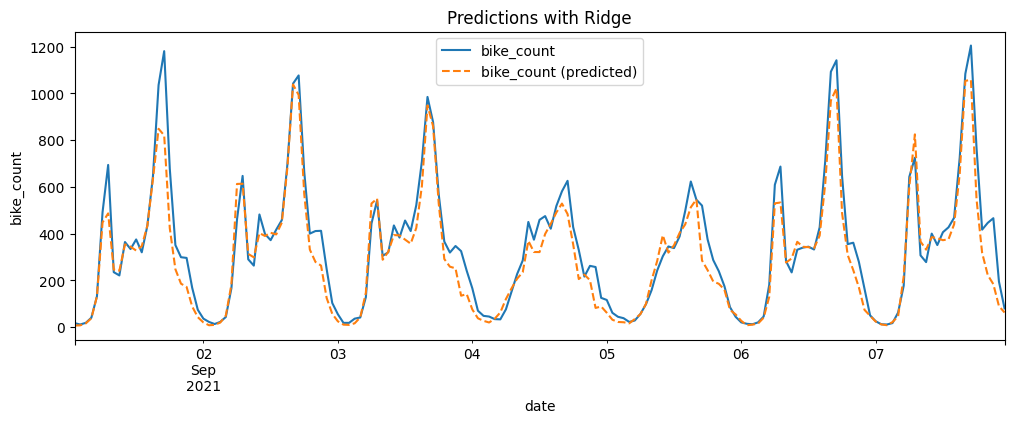

In [42]:
accuracy(pipe21)

## _CatBoost Regressor_

In [23]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train_comb[["date"]]).columns.tolist()
scaler = StandardScaler()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                      'Humidity', 'Visibility', 'pressure1','sunshine_time', 'suntime', 'new_cases']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("scaler", scaler, numerical_cols)
    ]
)


params ={'learning_rate': [.05,.1,.15],
         'max_depth':[8,10,12], 'iterations':[600,800], 'task_type': ['GPU'],
         'random_strength':[1,2]}

Boost = CatBoostRegressor()

pipe3 = make_pipeline(date_encoder, preprocessor, GridSearchCV(Boost,params,cv=3,verbose=10))

pipe3.fit(X_train_comb, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START iterations=600, learning_rate=0.05, max_depth=8, random_strength=1, task_type=GPU
0:	learn: 1.6409197	total: 10.5ms	remaining: 6.3s
1:	learn: 1.6041036	total: 18.5ms	remaining: 5.54s
2:	learn: 1.5701452	total: 27.5ms	remaining: 5.48s
3:	learn: 1.5369476	total: 36.8ms	remaining: 5.49s
4:	learn: 1.5058563	total: 45ms	remaining: 5.36s
5:	learn: 1.4769229	total: 54.5ms	remaining: 5.39s
6:	learn: 1.4511653	total: 96ms	remaining: 8.13s
7:	learn: 1.4261879	total: 107ms	remaining: 7.88s
8:	learn: 1.4036530	total: 116ms	remaining: 7.62s
9:	learn: 1.3809532	total: 127ms	remaining: 7.47s
10:	learn: 1.3608996	total: 136ms	remaining: 7.3s
11:	learn: 1.3422893	total: 144ms	remaining: 7.06s
12:	learn: 1.3255876	total: 154ms	remaining: 6.96s
13:	learn: 1.3072245	total: 162ms	remaining: 6.77s
14:	learn: 1.2904473	total: 171ms	remaining: 6.68s
15:	learn: 1.2743304	total: 180ms	remaining: 6.58s
16:	learn: 1.2594370	total: 

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001D43234AA70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', St...
                                                   'Temperature (C)',
                                                   'wind_speed', 'Humidity',
                                                   'Visibility', 'pressure1',
                                                   'sunshine_time', 'suntime',
                                                   'new_cases'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=3,
                              estimator=<catboost.core.CatBoostRegressor object at 0x000001D4023CB280>,
                              param_grid={'iterations': [600, 800],
                                          'learning_rate': [0.05, 0.1, 0.15],
                                          'max_depth': [8, 10, 12],
                                          'random_strength': [1, 2],
                                          'task_type': ['GPU']},
                              verbose=10))])

In [28]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = ["year", "month", "day", "weekday", "hour"]
scaler = StandardScaler()
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "wind_dir"]
numerical_cols = ['site_id', 'latitude', 'longitude', 'Temperature (C)', 'wind_speed',
                      'Humidity', 'Visibility', 'pressure1', 'sunshine_time', 'suntime', 'new_cases']

preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("scaler", scaler, numerical_cols)
        ]
    )
params = {'iterations': 800,
              'learning_rate': 0.1,
              'loss_function': 'RMSE',
              'random_strength': 2,
              'task_type': 'GPU',
              'max_depth': 10}

Boost = CatBoostRegressor(**params)

pipe2A = make_pipeline(date_encoder, preprocessor, Boost)

 
pipe2A.fit(X_train_comb, y_train)

0:	learn: 1.5797795	total: 15.8ms	remaining: 12.6s
1:	learn: 1.4971577	total: 30.3ms	remaining: 12.1s
2:	learn: 1.4265447	total: 45ms	remaining: 11.9s
3:	learn: 1.3651062	total: 58.5ms	remaining: 11.6s
4:	learn: 1.3135132	total: 73.2ms	remaining: 11.6s
5:	learn: 1.2669454	total: 87.3ms	remaining: 11.5s
6:	learn: 1.2284388	total: 103ms	remaining: 11.6s
7:	learn: 1.1885890	total: 120ms	remaining: 11.9s
8:	learn: 1.1550847	total: 136ms	remaining: 11.9s
9:	learn: 1.1286021	total: 150ms	remaining: 11.9s
10:	learn: 1.1039542	total: 165ms	remaining: 11.8s
11:	learn: 1.0797183	total: 182ms	remaining: 11.9s
12:	learn: 1.0591317	total: 197ms	remaining: 11.9s
13:	learn: 1.0359129	total: 212ms	remaining: 11.9s
14:	learn: 1.0185600	total: 227ms	remaining: 11.9s
15:	learn: 0.9997784	total: 243ms	remaining: 11.9s
16:	learn: 0.9849003	total: 257ms	remaining: 11.8s
17:	learn: 0.9702385	total: 272ms	remaining: 11.8s
18:	learn: 0.9526638	total: 287ms	remaining: 11.8s
19:	learn: 0.9367511	total: 302ms	rem

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001D43234AA70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wind_dir']),
                                                 ('scaler', StandardScaler(),
                                                  ['site_id', 'latitude',
                                                   'longitude',
                                                   'Temperature (C)',
                                                   'wind_speed', 'Humidity',
                                                   'Visibility', 'pressure1',
                                                   'sunshine_time', 'suntime',
                                                   'new_cases'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000001D40239BD30>)])

In [24]:
BestCGB = pipe3[2].best_estimator_
BestCGB

In [25]:
Params_CGB = BestCGB.get_params()
Params_CGB

{'iterations': 800,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'random_strength': 2,
 'task_type': 'GPU',
 'max_depth': 10}

In [27]:
pd.DataFrame(pipe3[2].cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        6.843154      1.077341         0.201064        0.006404   
1        5.989425      0.033914         0.181103        0.013247   
2        8.455108      0.019697         0.292217        0.007709   
3        8.552914      0.050983         0.281143        0.017808   
4       15.682133      0.083450         0.329734        0.012471   
5       16.176882      0.547445         0.327780        0.022579   
6        5.996695      0.005698         0.164882        0.012234   
7        6.019238      0.086338         0.161390        0.006371   
8        8.579522      0.037362         0.287355        0.005530   
9        8.617531      0.138679         0.275642        0.006677   
10      16.047428      0.228681         0.327733        0.023755   
11      16.092101      0.097607         0.344487        0.014817   
12       6.154764      0.032753         0.201204        0.002776   
13       6.262794      0.066459         0.224858        0.028221   
14       8.968435      0.114977         0.340165        0.016521   
15       8.954578      0.128845         0.339427        0.025003   
16      20.793229      3.363404         0.362043        0.022158   
17      19.433343      1.092244         0.412612        0.021806   
18       8.940327      0.069622         0.264112        0.024218   
19      10.397654      2.371670         0.207241        0.023270   
20      11.662775      0.100149         0.394810        0.017713   
21      11.759327      0.158453         0.359380        0.013423   
22      26.426714      2.823558         0.463106        0.008042   
23      24.766774      2.298048         0.458189        0.030642   
24       9.436968      1.704876         0.558355        0.481156   
25       8.042820      0.070241         0.231521        0.022505   
26      11.881441      0.155488         0.384824        0.017282   
27      12.142295      0.171136         0.382261        0.018341   
28      25.370483      2.190525         1.333123        1.290497   
29      24.739722      1.334888         1.642098        1.720609   
30       7.996310      0.152204         0.213687        0.015053   
31       8.372788      0.056230         0.242585        0.004684   
32      13.630151      2.241215         0.397460        0.020107   
33      15.602319      2.452708         0.390850        0.030213   
34      27.004996      0.157872         0.414522        0.020341   
35      27.120466      0.313986         0.404733        0.020576   

   param_iterations param_learning_rate param_max_depth param_random_strength  \
0               600                0.05               8                     1   
1               600                0.05               8                     2   
2               600                0.05              10                     1   
3               600                0.05              10                     2   
4               600                0.05              12                     1   
5               600                0.05              12                     2   
6               600                 0.1               8                     1   
7               600                 0.1               8                     2   
8               600                 0.1              10                     1   
9               600                 0.1              10                     2   
10              600                 0.1              12                     1   
11              600                 0.1              12                     2   
12              600                0.15               8                     1   
13              600                0.15               8                     2   
14              600                0.15              10                     1   
15              600                0.15              10                     2   
16              600                0.15              12                     1   
17              600          

In [151]:
joblib.dump(pipe3, 'CatBoost')
joblib.dump(pipe3[2].best_estimator_, 'CatBoost Best Model')

['CatBoost Best Model']

Train set, RMSE=0.37
Test set, RMSE=0.47
Train set, R^2=0.95
Test set, R^2=0.89


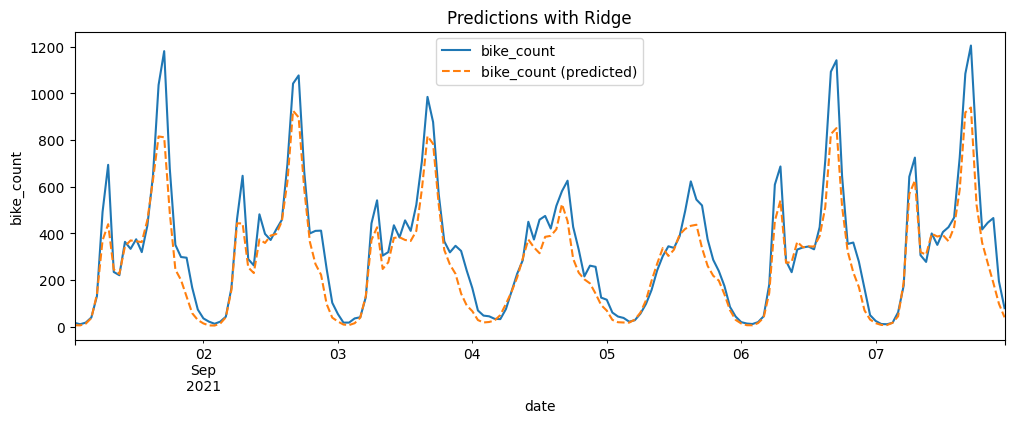

In [29]:
accuracy(pipe2A)